In [ ]:
import os
import shutil
import sys
from google.colab import drive

print("Setting up environment...")
drive.mount('/content/drive')

if not os.path.exists('/content/models'):
    print("Restoring Code...")
    !git clone https://github.com/Gabrysse/MLDL2024_project1.git temp_repo
    shutil.copytree('temp_repo/models', '/content/models')
    shutil.rmtree('temp_repo')

zip_path = '/content/drive/MyDrive/semseg/project_data.zip'

if not os.path.exists('/content/dataset/project_data/gta5'):
    print("Restoring Dataset...")
    if not os.path.exists('/content/dataset'): os.makedirs('/content/dataset')

    if os.path.exists(zip_path):
        shutil.unpack_archive(zip_path, '/content/dataset')
        print("Dataset restored.")
    else:
        print(f"Error: Zip file not found at {zip_path}")
else:
    print("Dataset already exists.")

Setting up environment...
Mounted at /content/drive
Restoring Code...
Cloning into 'temp_repo'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 34 (delta 9), reused 3 (delta 3), pack-reused 13 (from 1)
Receiving objects: 100% (34/34), 11.29 KiB | 481.00 KiB/s, done.
Resolving deltas: 100% (9/9), done.
Restoring Dataset...
Dataset restored.


In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from PIL import Image, ImageFilter
import torchvision.transforms as transforms
import numpy as np
import os
import random
from models.bisenet.build_bisenet import BiSeNet

# --- CONFIGURATION ---
CHECKPOINT_NAME = 'bisenet_aug2_checkpoint.pth'
EPOCHS = 50
BATCH_SIZE = 8
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
GTA_PATH = '/content/dataset/project_data/gta5'

# --- DATASET (AUG 2: PHOTOMETRIC) ---
class GTA5Aug2Dataset(Dataset):
    def __init__(self, root_dir):
        self.images_dir = os.path.join(root_dir, 'images')
        self.masks_dir = os.path.join(root_dir, 'labels')
        self.images = sorted(os.listdir(self.images_dir))
        self.color_jitter = transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1)
        self.normalize = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        self.id_mapping = {
            7: 0, 8: 1, 11: 2, 12: 3, 13: 4, 17: 5,
            19: 6, 20: 7, 21: 8, 22: 9, 23: 10, 24: 11, 25: 12,
            26: 13, 27: 14, 28: 15, 31: 16, 32: 17, 33: 18
        }

    def __len__(self): return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.images[idx])
        mask_path = os.path.join(self.masks_dir, self.images[idx])

        image = Image.open(img_path).convert('RGB').resize((1280, 720), Image.BILINEAR)
        mask = Image.open(mask_path).resize((1280, 720), Image.NEAREST)

        # AUG 2 ONLY: Color Jitter & Blur
        if random.random() > 0.5:
            image = self.color_jitter(image)
        if random.random() > 0.5:
            image = image.filter(ImageFilter.GaussianBlur(radius=random.uniform(0.1, 2.0)))

        image = self.normalize(image)
        mask_np = np.array(mask)
        target_mask = np.full(mask_np.shape, 255, dtype=np.uint8)
        for k, v in self.id_mapping.items(): target_mask[mask_np == k] = v
        return image, torch.from_numpy(target_mask).long()

# --- TRAINING LOOP ---
print(f"Starting Training for {CHECKPOINT_NAME}...")
model = BiSeNet(num_classes=19, context_path='resnet18').to(DEVICE)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss(ignore_index=255)

if os.path.exists(GTA_PATH):
    dataset = GTA5Aug2Dataset(GTA_PATH)
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    save_path = f'/content/drive/MyDrive/{CHECKPOINT_NAME}'

    for epoch in range(EPOCHS):
        model.train()
        for i, (img, lbl) in enumerate(loader):
            optimizer.zero_grad()
            out = model(img.to(DEVICE))
            loss = criterion(out[0], lbl.to(DEVICE)) + 0.1 * criterion(out[1], lbl.to(DEVICE)) + 0.1 * criterion(out[2], lbl.to(DEVICE))
            loss.backward()
            optimizer.step()

            if i % 50 == 0:
                print(f"Epoch [{epoch+1}/{EPOCHS}] Step [{i}/{len(loader)}] Loss: {loss.item():.4f}")

        torch.save({'model_state_dict': model.state_dict(), 'epoch': epoch}, save_path)
        print(f"Epoch {epoch+1} Saved.")
else:
    print("Dataset not found.")

Starting Training for bisenet_aug2_checkpoint.pth...
Epoch [1/50] Step [0/313] Loss: 4.5653
Epoch [1/50] Step [50/313] Loss: 0.8482
Epoch [1/50] Step [100/313] Loss: 0.8191
Epoch [1/50] Step [150/313] Loss: 0.7269
Epoch [1/50] Step [200/313] Loss: 0.5909
Epoch [1/50] Step [250/313] Loss: 0.6123
Epoch [1/50] Step [300/313] Loss: 0.5667
Epoch 1 Saved.
Epoch [2/50] Step [0/313] Loss: 0.5589
Epoch [2/50] Step [50/313] Loss: 0.4858
Epoch [2/50] Step [100/313] Loss: 0.4827
Epoch [2/50] Step [150/313] Loss: 0.7791
Epoch [2/50] Step [200/313] Loss: 0.4553
Epoch [2/50] Step [250/313] Loss: 0.3131
Epoch [2/50] Step [300/313] Loss: 0.4961
Epoch 2 Saved.
Epoch [3/50] Step [0/313] Loss: 0.4443
Epoch [3/50] Step [50/313] Loss: 0.3957
Epoch [3/50] Step [100/313] Loss: 0.4744
Epoch [3/50] Step [150/313] Loss: 0.3674
Epoch [3/50] Step [200/313] Loss: 0.3821
Epoch [3/50] Step [250/313] Loss: 0.4764
Epoch [3/50] Step [300/313] Loss: 0.3761
Epoch 3 Saved.
Epoch [4/50] Step [0/313] Loss: 0.3407
Epoch [4/50

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from PIL import Image, ImageFilter
import torchvision.transforms as transforms
import numpy as np
import os
import random
import sys

# Configuration
CHECKPOINT_PATH = '/content/drive/MyDrive/semseg/bisenet_aug2_checkpoint.pth'
TARGET_EPOCHS = 50
FORCED_START_EPOCH = 25
BATCH_SIZE = 8
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
GTA_PATH = '/content/dataset/project_data/gta5'

# Verify Checkpoint Exists
if not os.path.exists(CHECKPOINT_PATH):
    print(f"Error: Checkpoint not found at {CHECKPOINT_PATH}")
    sys.exit()

class GTA5Aug2Dataset(Dataset):
    def __init__(self, root_dir):
        self.images_dir = os.path.join(root_dir, 'images')
        self.masks_dir = os.path.join(root_dir, 'labels')
        self.images = sorted(os.listdir(self.images_dir))
        self.color_jitter = transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1)
        self.normalize = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        self.id_mapping = {
            7: 0, 8: 1, 11: 2, 12: 3, 13: 4, 17: 5,
            19: 6, 20: 7, 21: 8, 22: 9, 23: 10, 24: 11, 25: 12,
            26: 13, 27: 14, 28: 15, 31: 16, 32: 17, 33: 18
        }

    def __len__(self): return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.images[idx])
        mask_path = os.path.join(self.masks_dir, self.images[idx])

        image = Image.open(img_path).convert('RGB').resize((1280, 720), Image.BILINEAR)
        mask = Image.open(mask_path).resize((1280, 720), Image.NEAREST)

        # Photometric Augmentations
        if random.random() > 0.5: image = self.color_jitter(image)
        if random.random() > 0.5: image = image.filter(ImageFilter.GaussianBlur(radius=random.uniform(0.1, 2.0)))

        image = self.normalize(image)
        mask_np = np.array(mask)
        target_mask = np.full(mask_np.shape, 255, dtype=np.uint8)
        for k, v in self.id_mapping.items(): target_mask[mask_np == k] = v
        return image, torch.from_numpy(target_mask).long()

print(f"Resuming Training from Epoch {FORCED_START_EPOCH}...")
from models.bisenet.build_bisenet import BiSeNet
model = BiSeNet(num_classes=19, context_path='resnet18').to(DEVICE)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss(ignore_index=255)

# Load Checkpoint
checkpoint = torch.load(CHECKPOINT_PATH, map_location=DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])
if 'optimizer_state_dict' in checkpoint:
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

dataset = GTA5Aug2Dataset(GTA_PATH)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

for epoch in range(FORCED_START_EPOCH, TARGET_EPOCHS + 1):
    model.train()
    for i, (img, lbl) in enumerate(loader):
        optimizer.zero_grad()
        out = model(img.to(DEVICE))
        loss = criterion(out[0], lbl.to(DEVICE)) + 0.1 * criterion(out[1], lbl.to(DEVICE)) + 0.1 * criterion(out[2], lbl.to(DEVICE))
        loss.backward()
        optimizer.step()

        if i % 50 == 0:
            print(f"Epoch [{epoch}/{TARGET_EPOCHS}] Step [{i}/{len(loader)}] Loss: {loss.item():.4f}")

    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, CHECKPOINT_PATH)
    print(f"Epoch {epoch} Saved.")

Resuming Training from Epoch 25...
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 180MB/s]


Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


100%|██████████| 171M/171M [00:01<00:00, 133MB/s]


Epoch [25/50] Step [0/313] Loss: 0.1629
Epoch [25/50] Step [50/313] Loss: 0.1899
Epoch [25/50] Step [100/313] Loss: 0.1845
Epoch [25/50] Step [150/313] Loss: 0.1885
Epoch [25/50] Step [200/313] Loss: 0.1748
Epoch [25/50] Step [250/313] Loss: 0.1903
Epoch [25/50] Step [300/313] Loss: 0.1854
Epoch 25 Saved.
Epoch [26/50] Step [0/313] Loss: 0.2180
Epoch [26/50] Step [50/313] Loss: 0.2117
Epoch [26/50] Step [100/313] Loss: 0.1771
Epoch [26/50] Step [150/313] Loss: 0.2090
Epoch [26/50] Step [200/313] Loss: 0.1998
Epoch [26/50] Step [250/313] Loss: 0.1823
Epoch [26/50] Step [300/313] Loss: 0.1973
Epoch 26 Saved.
Epoch [27/50] Step [0/313] Loss: 0.1747
Epoch [27/50] Step [50/313] Loss: 0.1773
Epoch [27/50] Step [100/313] Loss: 0.1890
Epoch [27/50] Step [150/313] Loss: 0.2001
Epoch [27/50] Step [200/313] Loss: 0.2222
Epoch [27/50] Step [250/313] Loss: 0.2997
Epoch [27/50] Step [300/313] Loss: 0.2970
Epoch 27 Saved.
Epoch [28/50] Step [0/313] Loss: 0.2399
Epoch [28/50] Step [50/313] Loss: 0.214

In [ ]:
import torch
import os
import sys
import numpy as np
from torch.utils.data import DataLoader, Dataset
from models.bisenet.build_bisenet import BiSeNet
from PIL import Image
from tqdm import tqdm
import torchvision.transforms as transforms

# --- CONFIGURATION ---
CITYSCAPES_PATH = '/content/dataset/project_data/cityscapes'

CHECKPOINT_PATH = '/content/drive/MyDrive/semseg/bisenet_aug2_checkpoint.pth'
NUM_CLASSES = 19
BATCH_SIZE = 4
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

CLASSES = [
    "Road", "Sidewalk", "Building", "Wall", "Fence", "Pole",
    "Traffic Light", "Traffic Sign", "Vegetation", "Terrain", "Sky",
    "Person", "Rider", "Car", "Truck", "Bus", "Train", "Motorcycle", "Bicycle"
]

if os.path.exists('/content/models'): sys.path.append('/content/models')

class CityscapesDataset(Dataset):
    def __init__(self, root, split='val', transform=None):
        self.root = root
        self.transform = transform
        self.images_dir = os.path.join(root, 'leftImg8bit', split)
        self.masks_dir = os.path.join(root, 'gtFine', split)
        self.images = []
        self.masks = []

        if os.path.exists(self.images_dir):
            for city in sorted(os.listdir(self.images_dir)):
                img_dir_path = os.path.join(self.images_dir, city)
                mask_dir_path = os.path.join(self.masks_dir, city)
                if not os.path.isdir(img_dir_path): continue
                for file_name in sorted(os.listdir(img_dir_path)):
                    if file_name.endswith('_leftImg8bit.png'):
                        self.images.append(os.path.join(img_dir_path, file_name))
                        mask_name = file_name.replace('_leftImg8bit.png', '_gtFine_labelTrainIds.png')
                        self.masks.append(os.path.join(mask_dir_path, mask_name))

    def __len__(self): return len(self.images)
    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert('RGB').resize((1024, 512), Image.BILINEAR)
        mask = Image.open(self.masks[idx]).resize((1024, 512), Image.NEAREST)
        if self.transform: image = self.transform(image)
        return image, torch.from_numpy(np.array(mask)).long()

print(f"Evaluating: {CHECKPOINT_PATH}")
model = BiSeNet(num_classes=NUM_CLASSES, context_path='resnet18')
model.to(DEVICE)

if os.path.exists(CHECKPOINT_PATH):
    checkpoint = torch.load(CHECKPOINT_PATH, map_location=DEVICE)
    model.load_state_dict(checkpoint['model_state_dict'])
    print("Model weights loaded.")
else:
    print(f"Error: Checkpoint not found at {CHECKPOINT_PATH}")
    sys.exit()

model.eval()
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
dataset = CityscapesDataset(CITYSCAPES_PATH, split='val', transform=transform)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

hist = np.zeros((NUM_CLASSES, NUM_CLASSES))
print("Processing validation images...")

with torch.no_grad():
    for images, labels in tqdm(dataloader):
        images = images.to(DEVICE)
        labels = labels.numpy()
        output = model(images)
        if isinstance(output, tuple): output = output[0]
        preds = torch.argmax(output, dim=1).cpu().numpy()

        mask = (labels >= 0) & (labels < NUM_CLASSES)
        hist += np.bincount(
            NUM_CLASSES * labels[mask].astype(int) + preds[mask],
            minlength=NUM_CLASSES ** 2
        ).reshape(NUM_CLASSES, NUM_CLASSES)

iou = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist))
miou = np.nanmean(iou)

print("\n" + "="*40)
print(f"Final mIoU (Aug 2 Only): {miou * 100:.2f}%")
print("="*40)
print("-" * 40)
for i, class_name in enumerate(CLASSES):
    print(f"{class_name:15s}: {iou[i] * 100:.2f}%")
print("-" * 40)

Evaluating: /content/drive/MyDrive/semseg/bisenet_aug2_checkpoint.pth
Model weights loaded.
Processing validation images...


100%|██████████| 125/125 [01:04<00:00,  1.94it/s]


Final mIoU (Aug 2 Only): 30.87%
----------------------------------------
Road           : 76.10%
Sidewalk       : 29.20%
Building       : 75.23%
Wall           : 21.36%
Fence          : 16.78%
Pole           : 23.08%
Traffic Light  : 16.12%
Traffic Sign   : 13.91%
Vegetation     : 77.30%
Terrain        : 24.35%
Sky            : 79.41%
Person         : 43.08%
Rider          : 4.64%
Car            : 48.37%
Truck          : 15.80%
Bus            : 12.18%
Train          : 2.81%
Motorcycle     : 6.74%
Bicycle        : 0.00%
----------------------------------------


Loading best model: /content/drive/MyDrive/semseg/bisenet_aug2_checkpoint.pth


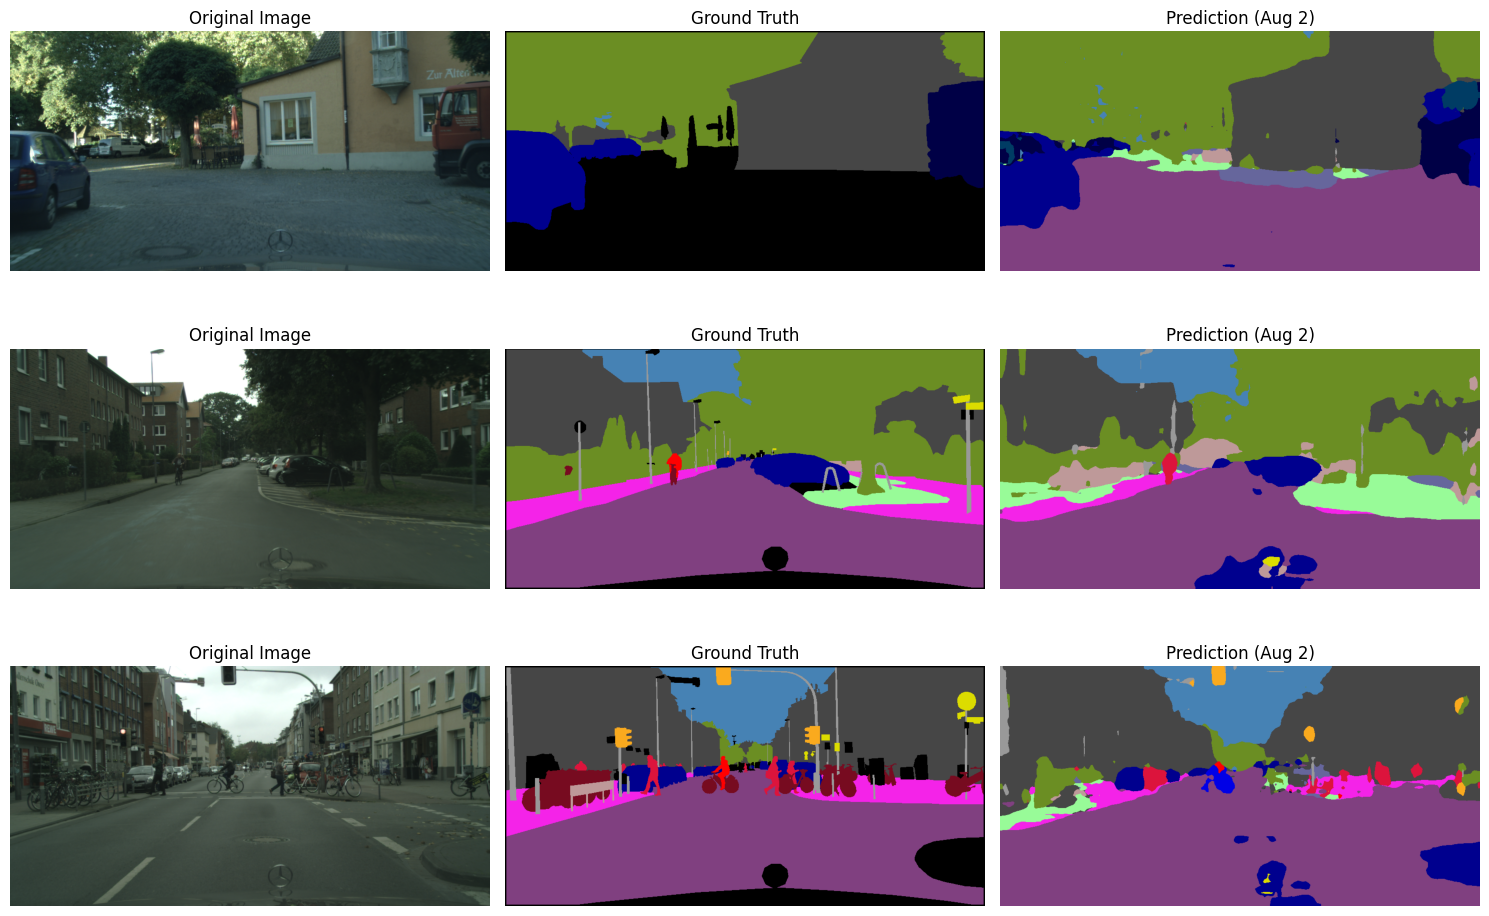

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import random
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import torchvision.transforms as transforms
from models.bisenet.build_bisenet import BiSeNet

# --- CONFIGURATION ---
# We use your BEST model (Aug 2) for visuals
CHECKPOINT_PATH = '/content/drive/MyDrive/semseg/bisenet_aug2_checkpoint.pth'
CITYSCAPES_PATH = '/content/dataset/project_data/cityscapes'
NUM_CLASSES = 19
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Cityscapes Color Palette (for visualization)
# This maps class IDs to colors (Road=Purple, Car=Blue, etc.)
PALETTE = torch.tensor([
    [128, 64, 128], [244, 35, 232], [70, 70, 70], [102, 102, 156],
    [190, 153, 153], [153, 153, 153], [250, 170, 30], [220, 220, 0],
    [107, 142, 35], [152, 251, 152], [70, 130, 180], [220, 20, 60],
    [255, 0, 0], [0, 0, 142], [0, 0, 70], [0, 60, 100],
    [0, 80, 100], [0, 0, 230], [119, 11, 32]
])

class CityscapesDataset(Dataset):
    def __init__(self, root, split='val', transform=None):
        self.root = root
        self.transform = transform
        self.images_dir = os.path.join(root, 'leftImg8bit', split)
        self.masks_dir = os.path.join(root, 'gtFine', split)
        self.images = []
        self.masks = []
        if os.path.exists(self.images_dir):
            for city in sorted(os.listdir(self.images_dir)):
                img_dir_path = os.path.join(self.images_dir, city)
                mask_dir_path = os.path.join(self.masks_dir, city)
                if not os.path.isdir(img_dir_path): continue
                for file_name in sorted(os.listdir(img_dir_path)):
                    if file_name.endswith('_leftImg8bit.png'):
                        self.images.append(os.path.join(img_dir_path, file_name))
                        mask_name = file_name.replace('_leftImg8bit.png', '_gtFine_labelTrainIds.png')
                        self.masks.append(os.path.join(mask_dir_path, mask_name))

    def __len__(self): return len(self.images)
    def __getitem__(self, idx):
        # Load original image for visualization (no normalization yet)
        original_img = Image.open(self.images[idx]).convert('RGB').resize((1024, 512), Image.BILINEAR)
        mask = Image.open(self.masks[idx]).resize((1024, 512), Image.NEAREST)
        return original_img, torch.from_numpy(np.array(mask)).long()

# Load Model
print(f"Loading best model: {CHECKPOINT_PATH}")
model = BiSeNet(num_classes=NUM_CLASSES, context_path='resnet18').to(DEVICE)
model.load_state_dict(torch.load(CHECKPOINT_PATH, map_location=DEVICE)['model_state_dict'])
model.eval()

# Helper to colorize masks
def colorize_mask(mask):
    # mask: [H, W] -> [H, W, 3]
    new_mask = torch.zeros((mask.shape[0], mask.shape[1], 3), dtype=torch.uint8)
    for cls_id in range(NUM_CLASSES):
        new_mask[mask == cls_id] = PALETTE[cls_id].byte()
    return new_mask.numpy()

# Transform for model input
norm_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = CityscapesDataset(CITYSCAPES_PATH, split='val')

# Visualize 3 random samples
indices = random.sample(range(len(dataset)), 3)

plt.figure(figsize=(15, 10))
for i, idx in enumerate(indices):
    raw_img, mask = dataset[idx]

    # Prepare input for model
    input_tensor = norm_transform(raw_img).unsqueeze(0).to(DEVICE)

    # Predict
    with torch.no_grad():
        output = model(input_tensor)
        if isinstance(output, tuple): output = output[0]
        pred_mask = torch.argmax(output, dim=1).squeeze(0).cpu()

    # Colorize
    gt_color = colorize_mask(mask)
    pred_color = colorize_mask(pred_mask)

    # Plot
    plt.subplot(3, 3, i*3 + 1)
    plt.imshow(raw_img)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(3, 3, i*3 + 2)
    plt.imshow(gt_color)
    plt.title("Ground Truth")
    plt.axis('off')

    plt.subplot(3, 3, i*3 + 3)
    plt.imshow(pred_color)
    plt.title("Prediction (Aug 2)")
    plt.axis('off')

plt.tight_layout()
plt.show()